In [1]:
#  Required imports

print("Importing standard library")
import math, os, sys, time

print("Importing python data libraries")
import numpy as np
from matplotlib import cm, pyplot as plt
from   scipy import stats

print("Importing third party libraries")
import dill as pickle

print("Importing custom backends")
sys.path.append("/Users/Ste/PostDoc/git-with-DP/SM-sandbox/proj5.4-EFT-Density-Estimation")
from backends.data_preparation import DataTable
from backends.density_model    import DensityModel, get_sum_gauss_density
from backends.plot             import plot_data, plot_ratio, plot_pull, get_ratio_1D
from backends.stats            import whiten_axes, unwhiten_axes
from backends.utils            import make_sure_dir_exists_for_filename

from backends import plot as plot, density_model as density_model

Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends


In [5]:
#  Inputs config

target_observable = "pT_ll"  # "Dy_j_j" # "m_jj" # "Dphi_j_j"

cWtil_vals = [0, 0.4]

input_fnames = {}
input_fnames [ 0  ] = "../Data/SM_EWK_1M_rivet_output.pickle"
input_fnames [-0.4] = "../Data/cWtil_m0p4_full_400k_rivet_output.pickle"
input_fnames [-0.3] = "../Data/cWtil_m0p3_full_400k_rivet_output.pickle"
input_fnames [-0.2] = "../Data/cWtil_m0p2_full_400k_rivet_output.pickle"
input_fnames [-0.1] = "../Data/cWtil_m0p1_full_400k_rivet_output.pickle"
input_fnames [ 0.1] = "../Data/cWtil_0p1_full_400k_rivet_output.pickle"
input_fnames [ 0.2] = "../Data/cWtil_0p2_full_400k_rivet_output.pickle"
input_fnames [ 0.3] = "../Data/cWtil_0p3_full_400k_rivet_output.pickle"
input_fnames [ 0.4] = "../Data/cWtil_0p4_full_400k_rivet_output.pickle"

#  "../Data/SM_EWK_rivet_output.pickle"
#  "../Data/SM_EWK_500k_rivet_output.pickle"
#  "../Data/SM_EWK_1M_rivet_output.pickle"


In [6]:
#  Model config

output_size_per_stage     = 20
max_epochs                = 1000
batch_sizes               = [1000]
early_stopping_patience   = 10
early_stopping_min_delta  = 0
validation_split          = 0.5
test_split                = 0.

white_linear_fraction_data_space   = 0.9     # Dphi_j_j is 0.8, otherwise 0.2
white_linear_fraction_latent_space = 0.      # Keep 0, otherwise we get hard boundaries on latent space
whitening_num_points               = 200

learning_rate  = 0.001      # 0.01 for SGD or 0.001 otherwise
optimiser      = "adam"     # SGD, Adam or AdaDelta
load_models    = False
load_whitening = False
save_plots     = True


In [7]:

class whitening_method :
    def __init__ (self, func_form, alpha=0., beta=0., gamma=0., load_file=None, save_file=None, load_model_dir=None, save_model_dir=None) :
        assert func_form in ["step", "gaus"]
        self.func_form      = func_form
        self.alpha          = alpha
        self.beta           = beta
        self.gamma          = gamma
        self.load_file      = load_file
        self.save_file      = save_file
        self.load_model_dir = load_model_dir
        self.save_model_dir = save_model_dir

whitening_gaus = whitening_method("gaus",          load_file=".white_funcs_paper_gaus.pickle", save_file=".white_funcs_paper_gaus.pickle", load_model_dir=".EWK_density_model_paper_gaus", save_model_dir=".EWK_density_model_paper_gaus")
whitening_step = whitening_method("step", 4, 3, 1, load_file=".white_funcs_paper_step.pickle", save_file=".white_funcs_paper_step.pickle", load_model_dir=".EWK_density_model_paper_step", save_model_dir=".EWK_density_model_paper_step")
whitening_methods = [whitening_step]


In [8]:
#  Data config

observable_limits = {}
observable_limits ["m_ll"      ] = [75    , 105  ]
observable_limits ["pT_ll"     ] = [0     , 900  ]
observable_limits ["theta_ll"  ] = [0     , np.pi]
observable_limits ["rap_ll"    ] = [0     , 2.2  ]
observable_limits ["m_jj"      ] = [150   , 5000 ]
observable_limits ["pT_jj"     ] = [0     , 900  ]
observable_limits ["theta_jj"  ] = [0     , np.pi]
observable_limits ["rap_jj"    ] = [0     , 4.4  ]
observable_limits ["pT_j1"     ] = [40    , 1200 ]
observable_limits ["pT_j2"     ] = [35    , 1200 ]
observable_limits ["Dy_j_j"    ] = [0     , 8.8  ]
observable_limits ["Dphi_j_j"  ] = [-np.pi, np.pi]
observable_limits ["N_jets"    ] = [2     , 5    ]
observable_limits ["N_gap_jets"] = [0     , 2    ]

remove_observables = [obs for obs in observable_limits if obs != target_observable] 

int_observables = ["N_jets", "N_gap_jets"]

observables_order = [target_observable]

plot.observable_limits = observable_limits
plot.int_observables   = int_observables

num_observables = len(observables_order)


In [9]:
#  Plots config
#  pT_ll
intervals = []

minor_intervals = []

x_prime = 500


#  Plots config
#  Dphi_jj

'''intervals = [[-np.pi, r"$-\pi$"], [-3.*np.pi/4., r"$-\frac{3\pi}{4}$"], [-np.pi/2., r"$-\frac{\pi}{2}$"],
             [-np.pi/4., r"$-\frac{\pi}{4}$"], [0, "$0$"], [np.pi/4., r"$\frac{\pi}{4}$"],
             [np.pi/2., r"$\frac{\pi}{2}$"], [3.*np.pi/4., r"$\frac{3\pi}{4}$"], [np.pi, r"$\pi$"]]

minor_intervals = [(i-16.)*np.pi/16. for i in range(32) if i % 4 != 0]

x_prime = 0.8'''


#  Plots config
#  m_jj

'''intervals = []

minor_intervals = []

x_prime = 2500'''


#  Plots config
#  Dy_j_j

'''intervals = []

minor_intervals = []

x_prime = 4.'''


'intervals = []\n\nminor_intervals = []\n\nx_prime = 4.'

In [10]:
#  Load and format the data
#

data_tables = {}
for cWtil in cWtil_vals :
    input_fname = input_fnames [cWtil]
    print(f"Creating data table for cWtil={cWtil}")
    print(f" -- events from file {input_fname}")
    data = DataTable(input_fname)
    print(f" -- Table created with {data.get_num_events()} events")
    for observable, limits in observable_limits.items() :
        print(f" -- filtering observable {observable} between {limits[0]} and {limits[1]}")
        data.filter(observable, limits[0], limits[1])
        print(f" -- {data.get_num_events()} events survived")
    for observable in remove_observables :
        print(f" -- removing observable {observable}")
        data.remove_column(observable)
    print(" -- ordering observables")
    data.reorder(*observables_order)
    data.print_summary()
    data_tables [cWtil] = data
    

Creating data table for cWtil=0
 -- events from file ../Data/SM_EWK_1M_rivet_output.pickle
 -- Table created with 1000000 events
 -- filtering observable m_ll between 75 and 105
 -- 660799 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 660766 events survived
 -- filtering observable theta_ll between 0 and 3.141592653589793
 -- 660766 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 652255 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 643177 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 643177 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 643177 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 643177 events survived
 -- filtering observable pT_j1 between 40 and 1200
 -- 643054 events survived
 -- filtering observable pT_j2 between 35 and 1200
 -- 642591 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 642591 events s

In [11]:

for white_meth in whitening_methods :
    
    whitening_funcs = None
    if (load_whitening) and (type(white_meth.load_file) != type(None) and (os.path.isfile(white_meth.load_file))) :
        print(f"Loading whitening functions from file {white_meth.load_file}")
        whitening_funcs = pickle.load(open(white_meth.load_file, "rb"))

    axis_configs = [[observable_limits[key][0], observable_limits[key][1], whitening_num_points,  white_linear_fraction_data_space, white_linear_fraction_latent_space] for key in data.keys]

    white_meth.observable_data, white_meth.weight_data, white_meth.white_data_to_fit = {}, {}, {}
    for cWtil in cWtil_vals :
        data = data_tables [cWtil]
        #  Seperate data from weights
        white_meth.observable_data [cWtil], white_meth.weight_data [cWtil] = data.get_observables_and_weights()
        #  Whiten data
        print(f"Whitening dataset for cWtil={cWtil}")
        white_meth.white_data_to_fit[cWtil], whitening_funcs = whiten_axes (white_meth.observable_data[cWtil], data.types, axis_configs=axis_configs, whitening_funcs=whitening_funcs, weights=data.get_weights(), 
                                                                            func_form=white_meth.func_form, alpha=white_meth.alpha, beta=white_meth.beta, gamma=white_meth.gamma)
        
    white_meth.white_data_to_test = {k:i[:int(test_split*len(i))] for k,i in white_meth.white_data_to_fit.items()}
    white_meth.white_data_to_fit  = {k:i[int(test_split*len(i)):] for k,i in white_meth.white_data_to_fit.items()}
    
    if len(intervals) > 0 :
        white_meth.white_intervals = whiten_axes (np.array([[i[0]] for i in intervals]), data.types, axis_configs=axis_configs, whitening_funcs=whitening_funcs, weights=[1 for i in intervals], 
                                                  func_form=white_meth.func_form, alpha=white_meth.alpha, beta=white_meth.beta, gamma=white_meth.gamma)[0]
    else : white_meth.white_intervals = []
    
    if len(minor_intervals) > 0 :
        white_meth.white_minor_intervals = whiten_axes (np.array([[i] for i in minor_intervals]), data.types, axis_configs=axis_configs, whitening_funcs=whitening_funcs, weights=[1 for i in minor_intervals], 
                                                        func_form=white_meth.func_form, alpha=white_meth.alpha, beta=white_meth.beta, gamma=white_meth.gamma)[0]
    else : white_meth.white_minor_intervals = []
    
    if type(white_meth.save_file) != type(None) :
        print(f"Saving whitening functions to file {white_meth.save_file}")
        pickle.dump(whitening_funcs, open(white_meth.save_file, "wb"))
        

Whitening dataset for cWtil=0
Whitening dataset for cWtil=0.4
Saving whitening functions to file .white_funcs_paper_step.pickle


In [12]:
#  Weight all training points equally
#

for white_meth in whitening_methods :
    white_meth.weights_to_test = {k:i[:int(test_split*len(i))]/np.sum(i[:int(test_split*len(i))]) for k,i in white_meth.weight_data.items()}
    white_meth.weights_to_fit  = {k:i[int(test_split*len(i)):]/np.sum(i[int(test_split*len(i)):]) for k,i in white_meth.weight_data.items()}
    

In [13]:
#  Save numbers required to plot whitening function
#

for white_meth in whitening_methods :

    alpha, beta , gamma      = white_meth.alpha, white_meth.beta, white_meth.gamma
    axmin, axmax, ax_npoints = observable_limits[target_observable][0], observable_limits[target_observable][1], whitening_num_points
    ax_scan_points           = np.linspace(axmin, axmax, 1+ax_npoints)
    data_frac_constant       = white_linear_fraction_data_space
    gauss_frac_constant      = white_linear_fraction_latent_space
    dataset   = white_meth.observable_data[0][:,0]
    weights   = white_meth.weights_to_fit [0]
    ds_and_w  = np.array([(x,w) for x, w in zip(dataset, weights) if (x>axmin and x<axmax)])
    dataset, weights = [x[0] for x in ds_and_w], [x[1] for x in ds_and_w]
    weights   = weights / np.sum(weights)
    func_form = white_meth.func_form
        
    print("Getting data c.d.f.")
    data_cdf = []
    for A in ax_scan_points :
        sys.stdout.write(f"\rScan point is: {A:.4f}  ----------")
        data_cdf.append(np.sum([w for x,w in zip(dataset, weights) if x < A]))
    data_cdf     = np.array(data_cdf)
    constant_cdf = (ax_scan_points - axmin) / (axmax - axmin)
    combined_cdf = data_frac_constant*constant_cdf + (1-data_frac_constant)*data_cdf
    
    white_meth.ax_scan_points = ax_scan_points
    white_meth.cdf_data, white_meth.cdf_data_linear, white_meth.cdf_x = data_cdf, constant_cdf, combined_cdf

    print("\nGetting latent c.d.f.")
    if func_form == "step" :
        white_space_x   = np.linspace(-6, 6, 241)
        Smooth_step_y   = 1. / (1 + np.exp((white_space_x-beta)*alpha-gamma)) / (1 + np.exp(-(white_space_x+beta)*alpha-gamma))
        white_meth.white_space_y = Smooth_step_y
        Smooth_step_cdf = np.array([np.sum(Smooth_step_y[:i+1]) for i in range(len(Smooth_step_y))])
        Smooth_step_cdf = Smooth_step_cdf / Smooth_step_cdf[-1]
        Smooth_step_cdf[0] = 0.
        constant_cdf    = (white_space_x + 5.) / 10.
        white_space_cdf = gauss_frac_constant*constant_cdf + (1-gauss_frac_constant)*Smooth_step_cdf
        white_meth.cdf_target    = Smooth_step_cdf
        white_meth.white_space_x = white_space_x
    else :
        white_space_x   = np.linspace(-6, 6, 241)
        white_meth.white_space_y = stats.norm.pdf(white_space_x)
        Gauss_cdf       = stats.norm.cdf(white_space_x)
        Gauss_cdf[0], Gauss_cdf[-1] = 0., 1.
        constant_cdf    = (white_space_x + 5.) / 10.
        white_space_cdf = gauss_frac_constant*constant_cdf + (1-gauss_frac_constant)*Gauss_cdf 
        white_meth.cdf_target    = Gauss_cdf
        white_meth.white_space_x = white_space_x
        
    white_meth.white_space_x = white_space_x
    white_meth.cdf_latent_linear, white_meth.cdf_u = constant_cdf, white_space_cdf
    
    print("Done")


Getting data c.d.f.
Scan point is: 900.0000  ----------
Getting latent c.d.f.
Done


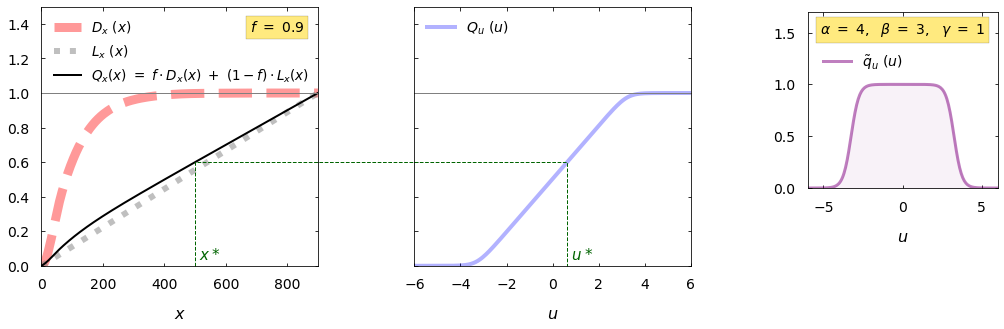

In [14]:
#  Plot whitening functions
#

for white_meth in whitening_methods :
    y_prime = np.interp(x_prime, white_meth.ax_scan_points, white_meth.cdf_x        )
    u_prime = np.interp(y_prime, white_meth.cdf_u         , white_meth.white_space_x)
    
    fig    = plt.figure(figsize=(14., 0.8*4.5))
    ax     = fig.add_axes([0.01, 0.01, 0.32*12./14., 1.])
    plot_x = white_meth.ax_scan_points
    ax.plot(plot_x, white_meth.cdf_data        , "-", linestyle="--", lw=9, c="r"   , alpha=0.4, label="$D_x~(x)$")
    ax.plot(plot_x, white_meth.cdf_data_linear , "-", linestyle=":" , lw=6, c="grey", alpha=0.5, label="$L_x~(x)$")
    ax.plot(plot_x, white_meth.cdf_x           , "-", linestyle="-" , lw=2, c="k"   , label="$Q_x(x) ~=~ f\cdot D_x(x) ~+~ (1-f)\cdot L_x(x)$")
    ax.axhline(1, linestyle="-", color="grey", linewidth=1)
    ax.set_xlim([plot_x[0], plot_x[-1]])
    ax.set_ylim([0        , 1.5])
    ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14, pad=12)
    ax.set_xlabel("$x$"   , fontsize=16, labelpad=15)
    ax.legend(loc="upper left", fontsize=13.5, frameon=False)
    ax.plot([x_prime, x_prime, 2*plot_x[-1]-plot_x[0]], [0, y_prime, y_prime], "--", c="darkgreen", lw=1, clip_on=False)
    ax.text(x_prime, 0.02, " $x*$", ha="left", va="bottom", fontsize=15, c="darkgreen")
    ax.text(0.95, 0.95, f"$f~=~{white_linear_fraction_data_space:.1f}$", ha="right", va="top", fontsize=14, transform=ax.transAxes, bbox=dict(facecolor="gold", alpha=0.5, linewidth=0.3))
    
    ax     = fig.add_axes([0.38, 0.01, 0.32*12./14., 1.])
    plot_x = white_meth.white_space_x
    ax.plot(plot_x, white_meth.cdf_u, "-", linestyle="-" , lw=4, c="b", label="$Q_u~(u)$", alpha=0.3)
    ax.axhline(1, linestyle="-", color="grey", linewidth=1)
    ax.set_xlim([plot_x[0], plot_x[-1]])
    ax.set_ylim([0        , 1.5])
    ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14, pad=12)
    ax.get_yaxis().set_ticklabels([])
    ax.set_xlabel("$u$"   , fontsize=16, labelpad=15)
    ax.legend(loc="upper left", fontsize=14, frameon=False)
    ax.plot([plot_x[0], u_prime, u_prime], [y_prime, y_prime, 0], "--", c="darkgreen", lw=1, clip_on=False)
    ax.text(u_prime, 0.02, " $u*$", ha="left", va="bottom", fontsize=15, c="darkgreen")
    
    ax     = fig.add_axes([0.77, 0.31, 0.22*12./14., 0.68])
    ax.plot(white_meth.white_space_x, white_meth.white_space_y, "-", linestyle="-", lw=3, c="purple", label=r"${\tilde q}_u~(u)$", alpha=0.5)
    ax.fill_between(white_space_x, np.zeros(shape=white_meth.white_space_x.shape), white_meth.white_space_y, color="purple", alpha=0.05)
    ax.set_xlim([white_space_x[0], white_space_x[-1]])
    maxy = 1.7*np.max(white_meth.white_space_y)
    ax.set_ylim([0        , maxy])
    ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14, pad=12)
    ax.set_xlabel("$u$"   , fontsize=16, labelpad=15)
    ax.legend(loc=(0.05, 0.63), fontsize=14, frameon=False) 
    ax.text(0.5, 0.95, r"$\alpha~="+f"~{white_meth.alpha:.0f}"+r",~~\beta ~="+f"~{white_meth.beta :.0f}"+r",~~\gamma~="+f"~{white_meth.gamma:.0f}$", ha="center", va="top", fontsize=14, transform=ax.transAxes, bbox=dict(facecolor="gold", alpha=0.5, linewidth=0.3))
    
    plt.subplots_adjust(wspace=0.2, left=0.01, right=0.99)
    if save_plots :
        plt.savefig(f"figures/whitening_method/projection_functions_{target_observable}.pdf", bbox_inches="tight")
    plt.show()

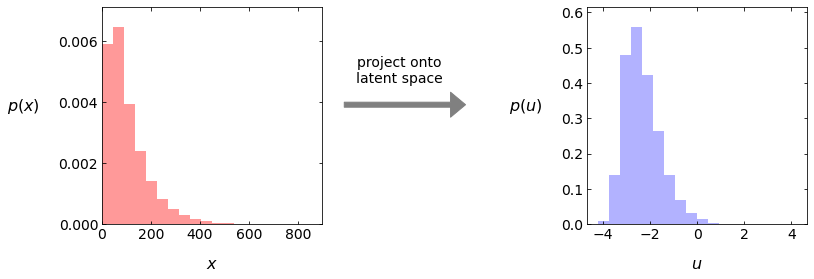

In [15]:
#  Weight all training points equally
#  -  and plot original / laten distributions
#

for white_meth in whitening_methods :
    fig = plt.figure(figsize=(10, 4))

    ax   = fig.add_subplot(1, 2, 1)
    bins = np.linspace(observable_limits[target_observable][0], observable_limits[target_observable][1], 21)
    vals, _, _ = ax.hist(white_meth.observable_data[0], weights=white_meth.weight_data[0], bins=bins, density=True, color="r", alpha=0.4)
    hmax = 1.1 * np.max(vals)
    ax.set_xlim([bins[0], bins[-1]])
    ax.set_ylim([0      , hmax])
    ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
    ax.set_ylabel("$p(x)$", fontsize=16, labelpad=35, rotation=0)
    ax.set_xlabel("$x$"   , fontsize=16, labelpad=15)
    
    for idx, i in enumerate(intervals) :
        lw = 2.+2*np.fabs(math.floor(len(intervals)/2.)-idx)/len(intervals)
        ax.axvline(i[0], linestyle="--", c="grey", linewidth=lw)
        ax.text(i[0], 1.1*hmax, i[1], c="grey", fontsize=12, ha="center")
        ax.plot([i[0], i[0]], [hmax, 1.05*hmax], linestyle="--", c="grey", linewidth=lw, clip_on=False)
    
    for i in minor_intervals :
        ax.axvline(i, linestyle=":", c="grey", linewidth=1.)
        
    ax   = fig.add_subplot(1, 2, 2)
    edge = np.max(np.fabs(white_meth.white_data_to_fit[0]))
    bins = np.linspace(-edge, edge, 21)
    vals , _, _ = ax.hist(white_meth.white_data_to_fit[0], weights=white_meth.weights_to_fit[0], bins=bins, density=True, color="b", alpha=0.3)
    hmax = 1.1 * np.max(vals)
    #ax.set_xlim([white_meth.white_intervals[0], white_meth.white_intervals[-1]])
    ax.set_xlim([np.min(np.concatenate([bins, [i[0] for i in white_meth.white_intervals]])), np.max(np.concatenate([bins, [i[0] for i in white_meth.white_intervals]]))])
    #ax.set_xlim([bins[0], bins[-1]])
    ax.set_ylim([0      , hmax])
    ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
    ax.set_ylabel("$p(u)$", fontsize=16, labelpad=35, rotation=0)
    ax.set_xlabel("$u$"   , fontsize=16, labelpad=15)
    
    for idx, (i, wi) in enumerate(zip(intervals, white_meth.white_intervals)) :
        lw = 2.+2*np.fabs(math.floor(len(intervals)/2.)-idx)/len(intervals)
        ax.axvline(wi[0], linestyle="--", c="grey", linewidth=lw)
        xlo, xhi, xrange = bins[0], bins[-1], bins[-1] - bins[0]
        label_pos        = xlo + xrange*(idx/(len(intervals)-1.)), 1.1*hmax, 1.05*hmax
        line_pos         = wi[0], hmax
        ax.text(label_pos[0], label_pos[1], i[1], c="grey", fontsize=12, ha="center")
        ax.plot([line_pos[0], label_pos[0]], [line_pos[1], label_pos[2]], linestyle="--", c="grey", linewidth=lw, clip_on=False)
        
    for wi in white_meth.white_minor_intervals :
        ax.axvline(wi, linestyle=":", c="grey", linewidth=1.)
        
    ax.text(-0.85, 0.65, "project onto\nlatent space", transform=ax.transAxes, ha="center", fontsize=14)
    
    ax.annotate("", xy=(-0.55, 0.55), xycoords  ="axes fraction",
                xytext=(-1.1 , 0.55), textcoords="axes fraction",
                arrowprops=dict(width=5, headwidth=25, headlength=15, facecolor="grey", edgecolor="grey"))
    
    plt.subplots_adjust(wspace=1.2, left=0.01, right=0.99)
    if save_plots :
        plt.savefig(f"figures/whitening_method/projection_distributions_{target_observable}.pdf", bbox_inches="tight")
    plt.show()
    

In [16]:
#  Plotting mixture of Gaussians, since it was observed that -ve deviations around SM are hard to model
#       if the distribution is dominated by a single Gaussian mode

def plot_mixture_model (savefig=None) :

    colours   = cm.get_cmap('brg', output_size_per_stage)   # 'hsv'
    newcolors = colours(np.linspace(0, 1, output_size_per_stage))
    x         = np.linspace(-6, 6, 241)
    bins      = np.linspace(-6, 6, 61)

    for white_meth in whitening_methods :

        fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(9, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

        density_model = white_meth.density_model

        params = density_model.likelihood_models[0].get_gauss_params([0])[0]
        fracs  = params[:output_size_per_stage]
        means  = params[output_size_per_stage:2*output_size_per_stage]
        sigmas = params[2*output_size_per_stage:3*output_size_per_stage]
        print("fracs", fracs)
        print("means", means)
        print("sigmas", sigmas)

        ds, weights = white_meth.white_data_to_fit[0][:,0], white_meth.weights_to_fit[0]

        y1, int1 = 0., 0.
        bin_entries , _  = np.histogram(ds, weights=weights, bins=bins)
        bin_variance, _  = np.histogram(ds, weights=weights*weights, bins=bins)
        frac_errors      = np.sqrt(bin_variance) / bin_entries
        hvals1, _, _     = ax0.hist(ds, weights=weights, density=True, color="darkgrey", alpha=0.5, bins=bins, label=r"MG5 events (${\tilde c}_W=0$)")
        for i in range(output_size_per_stage) :
            yp   = fracs[i]*stats.norm.pdf(x, means[i], sigmas[i])
            y1   = y1 + yp
            int1 = int1 + np.array([fracs[i]*(stats.norm.cdf(bins[j+1], means[i], sigmas[i])-stats.norm.cdf(bins[j], means[i], sigmas[i]))/(bins[j+1]-bins[j]) for j in range(len(bins)-1)])
            ax0.plot(x, yp, c=newcolors[i], linewidth=1, linestyle="--")
        ax0.plot(x, y1, c="k", linewidth=3, linestyle="--", label=r"$p_\phi~(~u~|~{\tilde c}_W=0~)$")

        ax0.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
        #ax0.set_title(r"${\tilde c}_W ~=~ 0$", fontsize=18, pad=10)
        ax0.set_ylabel("$p(u)$", fontsize=16, labelpad=45, rotation=0)
        ax0.legend(loc="upper left", frameon=False, fontsize=14)

        rat_x, rat_y, rat_ey = [], [], []
        for idx, b in enumerate(bins) :
            rat_x.append(b)
            if (idx==0) or (idx==len(bins)-1) : continue
            rat_x.append(b)
        for y, ey in zip(hvals1/int1 - 1, frac_errors*hvals1/int1) :
            rat_y .append(y )
            rat_y .append(y )
            rat_ey.append(ey)
            rat_ey.append(ey)
        rat_x, rat_y, rat_ey = np.array(rat_x), np.array(rat_y), np.array(rat_ey)

        ax2.axhline(0, linestyle="--", c="k", linewidth=3)
        ax2.axhline(-0.10, linestyle=":" , c="grey", linewidth=1)
        ax2.axhline(-0.05, linestyle=":" , c="grey", linewidth=1)
        ax2.axhline(0.05 , linestyle=":" , c="grey", linewidth=1)
        ax2.axhline(0.10 , linestyle=":" , c="grey", linewidth=1)
        ax2.set_yticks([-0.1, 0, 0.1])
        ax2.yaxis.set_ticklabels(["$-10\%$", "$0$", "$+10\%$"])
        ax2.plot(rat_x, rat_y, "-", c="darkgrey")
        ax2.fill_between(rat_x, rat_y-rat_ey, rat_y+rat_ey, color="darkgrey", alpha=0.5)
        ax2.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
        ax2.set_xlabel("$u$"   , fontsize=18, labelpad=15)
        ax2.set_ylabel(r"$\frac{p(u)~-~p_\phi(u)}{p_\phi(u)}$", fontsize=21, labelpad=70, rotation=0)
        ax2.set_ylim  ([-0.15, 0.15])

        params = density_model.likelihood_models[0].get_gauss_params([0.4])[0]
        fracs  = params[:output_size_per_stage]
        means  = params[output_size_per_stage:2*output_size_per_stage]
        sigmas = params[2*output_size_per_stage:3*output_size_per_stage]

        ds, weights = white_meth.white_data_to_fit[0.4][:,0], white_meth.weights_to_fit[0.4]

        y2, int2 = 0., 0.
        bin_entries , _  = np.histogram(ds, weights=weights, bins=bins)
        bin_variance, _  = np.histogram(ds, weights=weights*weights, bins=bins)
        frac_errors      = np.sqrt(bin_variance) / bin_entries
        hvals2, _, _     = ax1.hist(ds, weights=weights, density=True, color="darkgrey", alpha=0.5, bins=bins, label=r"MG5 events (${\tilde c}_W=0.4$)")
        for i in range(output_size_per_stage) :
            yp   = fracs[i]*stats.norm.pdf(x, means[i], sigmas[i])
            y2   = y2 + yp
            int2 = int2 + np.array([fracs[i]*(stats.norm.cdf(bins[j+1], means[i], sigmas[i])-stats.norm.cdf(bins[j], means[i], sigmas[i]))/(bins[j+1]-bins[j]) for j in range(len(bins)-1)])
            ax1.plot(x, yp, c=newcolors[i], linewidth=1, linestyle="--")
        ax1.plot(x, y1, c="k"   , linewidth=3, linestyle="--")
        ax1.plot(x, y2, c="grey", linewidth=3, linestyle="--", label=r"$p_\phi~(~u~|~{\tilde c}_W=0.4~)$")

        ax1.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
        ax1.legend(loc="upper left", frameon=False, fontsize=14)

        rat_y2, rat_ey2, rat_1_over_2 = [], [], []
        for y, ey, f in zip(hvals2/int2 - 1, frac_errors*hvals2/int2, int1/int2 - 1) :
            rat_y2      .append(y )
            rat_y2      .append(y )
            rat_ey2     .append(ey)
            rat_ey2     .append(ey)
            rat_1_over_2.append(f )
            rat_1_over_2.append(f )
        rat_y2, rat_ey2 = np.array(rat_y2), np.array(rat_ey2)

        ax3.axhline(0    , linestyle="--", c="grey", linewidth=3)
        ax3.axhline(-0.10, linestyle=":" , c="grey", linewidth=1)
        ax3.axhline(-0.05, linestyle=":" , c="grey", linewidth=1)
        ax3.axhline(0.05 , linestyle=":" , c="grey", linewidth=1)
        ax3.axhline(0.10 , linestyle=":" , c="grey", linewidth=1)
        ax3.plot(rat_x, rat_y2      , "-" , c="darkgrey")
        ax3.fill_between(rat_x, rat_y2-rat_ey2, rat_y2+rat_ey2, color="darkgrey", alpha=0.5)
        ax3.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
        ax3.set_xlabel("$u$"   , fontsize=18, labelpad=15)
        ax3.set_ylim  ([-0.15, 0.15])

        ax3.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
        ax3.set_xlabel("$u$"   , fontsize=18, labelpad=15)

        ax0.set_xlim([x[0], x[-1]])
        ax1.set_xlim([x[0], x[-1]])
        hmax = np.max([np.max(hvals1), np.max(hvals2)])
        ax0.set_ylim([0, 1.4*hmax])
        ax1.set_ylim([0, 1.4*hmax])
        ax1.yaxis.set_ticklabels([])
        ax3.yaxis.set_ticklabels([])

        plt.subplots_adjust(hspace=0.05, wspace=0.2, left=0.01, right=0.99)
        if type(savefig) is str :
            plt.savefig(savefig, bbox_inches="tight")
        plt.show()


INFO       DensityModel.construct      Set model name              : EWK_density_model
INFO       DensityModel.construct      Set model num_gaussians     : 20
INFO       DensityModel.construct      Set model num_conditions    : 1
INFO       DensityModel.construct      Set model num_observables   : 1
INFO       DensityModel.construct      Set observable types        : [<class 'float'>]
INFO       DensityModel.construct      Set kernel_initializer      : glorot_uniform
INFO       DensityModel.construct      Set bias_initializer        : zeros
INFO       DensityModel.construct      Set learning_rate           : 0.001
INFO       DensityModel.construct      Set optimiser               : adam
INFO       DensityModel.construct      Set activation              : leakyrelu
INFO       DensityModel.construct      Set min_gauss_amplitude_frac: 0.2
INFO       DensityModel.build          Building model segment: EWK_density_model_observable0 for observable index 0
Creating continuous density model: E

W0128 11:38:31.293957 4675151296 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2070: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


fracs [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05 0.05 0.05 0.05 0.05]
means [-4.4507103  -4.0048623  -3.5590148  -3.1131673  -2.6673198  -2.2214723
 -1.7756245  -1.329777   -0.8839294  -0.4380818   0.00776578  0.45361337
  0.899461    1.3453085   1.7911562   2.2370038   2.6828513   3.1286988
  3.5745466   4.020394  ]
sigmas [0.0530444 0.0530444 0.0530444 0.0530444 0.0530444 0.0530444 0.0530444
 0.0530444 0.0530444 0.0530444 0.0530444 0.0530444 0.0530444 0.0530444
 0.0530444 0.0530444 0.0530444 0.0530444 0.0530444 0.0530444]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in true_divide


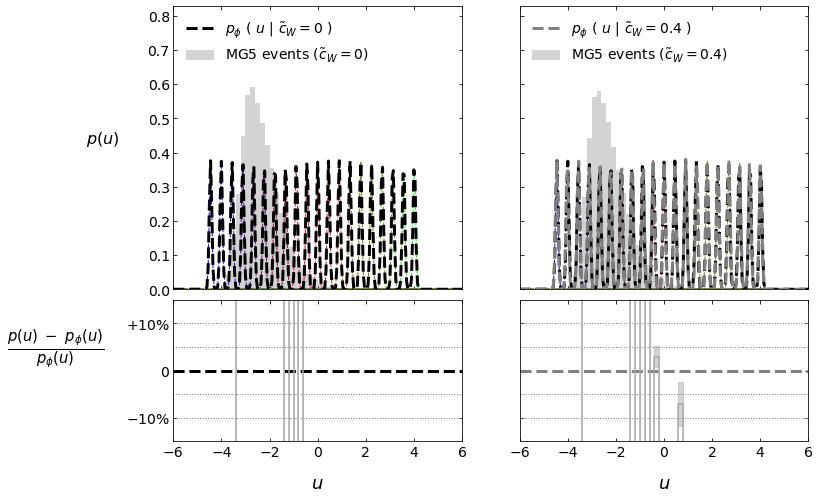

Setting batch size to 1000
INFO       DensityModel.fit            Queued the following observable indices to train: 0
INFO       DensityModel.fit            Parsing training data
INFO       DensityModel.fit            Training observable index 0
INFO       DensityModel.fit              -  Training setting: epochs = 1000
INFO       DensityModel.fit              -  Training setting: batch_size = 1000
INFO       DensityModel.fit              -  Training setting: validation_split = 0.5
INFO       DensityModel.fit              -  Training setting: early_stopping_patience = 10
INFO       DensityModel.fit              -  Training setting: early_stopping_min_delta = 0
Train on 450066 samples, validate on 450067 samples
Epoch 1/1000
450066/450066 [==============================] - 3s 6us/sample - loss: 5.2724e-06 - val_loss: 3.6801e-06
Epoch 2/1000
450066/450066 [==============================] - 3s 6us/sample - loss: 3.0113e-06 - val_loss: 2.7089e-06
Epoch 3/1000
450066/450066 [===============

Epoch 64/1000
450066/450066 [==============================] - 3s 6us/sample - loss: 2.4928e-06 - val_loss: 2.4948e-06
Epoch 65/1000
450066/450066 [==============================] - 3s 6us/sample - loss: 2.4925e-06 - val_loss: 2.4952e-06
Fit completed in 184s


In [17]:
#  Load model if requested, otherwise build and fit
#

import tensorflow as tf

density_model.Gauss_width_reduction_factor = 8.

#kernel_init = "zeros"
kernel_init = "glorot_uniform"
#kernel_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
#kernel_init = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=None)

bias_init   = "zeros"
#bias_init   = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None)
#bias_init   = tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.3, seed=None)


for white_meth in whitening_methods :
    #  Load density model if requested
    if (type(white_meth.load_model_dir) != type(None)) and (os.path.exists(white_meth.load_model_dir)) and (load_models) :
        white_meth.density_model = DensityModel.from_dir(white_meth.load_model_dir)
    else :
        #
        #   Figure out the limits of the observables
        #
        range_limits = {}
        for idx in range(num_observables) :
            all_data   = np.concatenate([item[:,idx] for c,item in white_meth.white_data_to_fit.items()])
            imin, imax = np.min(all_data), np.max(all_data)
            irange     = imax - imin
            #range_limits[idx] = [imin, imax]
            #range_limits[idx] = [imin - 0.5*irange/output_size_per_stage, imax + 0.5*irange/output_size_per_stage] 
            range_limits[idx] = [imin + 0.5*irange/output_size_per_stage, imax - 0.5*irange/output_size_per_stage] 
        #
        #   Create density model  
        #
        white_meth.density_model = DensityModel(name            = "EWK_density_model", 
                                                num_gaussians   = output_size_per_stage, 
                                                num_conditions  = 1, 
                                                num_observables = data.get_num_observables(), 
                                                types           = data.types,
                                                int_limits      = {idx:observable_limits[obs] for idx,(obs,t) in enumerate(zip(data.keys, data.types)) if t == int},
                                                verbose         = True,
                                                learning_rate   = learning_rate,
                                                optimiser       = optimiser,
                                                range_limits    = range_limits,
                                                kernel_initializer = kernel_init,
                                                bias_initializer   = bias_init)
        plot_mixture_model()
        #
        #   Fit density model
        #
        for batch_size in batch_sizes :
            print(f"Setting batch size to {batch_size}")
            white_meth.density_model.fit(white_meth.white_data_to_fit, 
                                         white_meth.weights_to_fit,
                                         observable                = 0,
                                         max_epochs_per_observable = max_epochs,
                                         early_stopping_patience   = early_stopping_patience,
                                         early_stopping_min_delta  = early_stopping_min_delta,
                                         validation_split          = validation_split,
                                         batch_size_per_observable = batch_size)


In [18]:
#  Save model if requested

for white_meth in whitening_methods :
    if type(white_meth.save_model_dir) != type(None) :
        white_meth.density_model.save_to_dir(white_meth.save_model_dir)
        

fracs [0.01073086 0.01000364 0.010164   0.16388457 0.13556236 0.33832115
 0.02004099 0.01284782 0.18837705 0.01000258 0.01000621 0.01004228
 0.01000025 0.01000157 0.01000501 0.01000422 0.0100015  0.01000076
 0.01000191 0.01000133]
means [-3.1775033  -2.6410294  -3.2826254  -2.9574306  -2.813142   -2.3862891
 -1.2425421  -1.6940774  -1.765764   -1.9018013  -2.5288877  -2.4386036
 -1.2172543  -1.7299583  -0.03980122 -1.4504001   4.1257734  -0.72781146
 -1.6787262   0.16114399]
sigmas [0.30872145 0.3613665  0.23144266 0.30839255 0.3926873  0.5054012
 0.74384165 0.39457685 0.6868754  0.42311937 0.48236933 0.5054756
 0.4935083  0.71287954 0.4055324  0.7430395  0.04097781 0.5813759
 0.72134    1.075146  ]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide


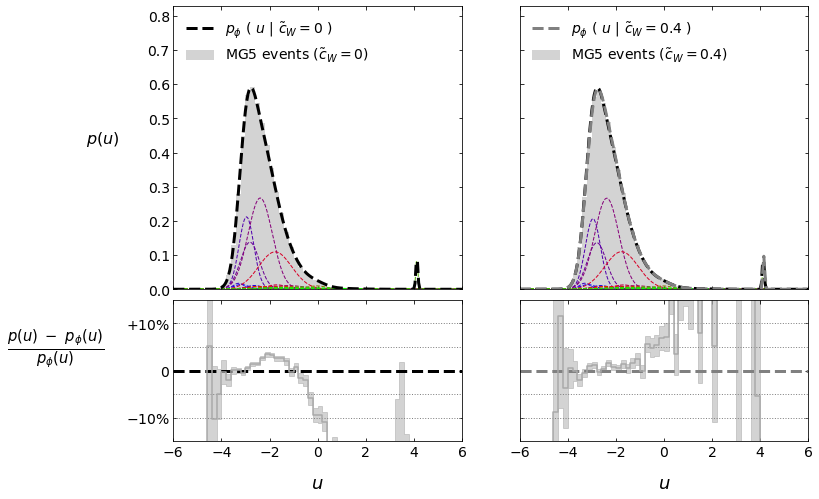

In [19]:
#  Plotting mixture of Gaussians, since it was observed that -ve deviations around SM are hard to model
#       if the distribution is dominated by a single Gaussian mode

plot_mixture_model(savefig=f"figures/whitening_method/fitted_distributions_1D_{target_observable}_v2.pdf")
#plot_mixture_model()


In [ ]:

func = lambda xp, alpha, beta, gamma : 1. / (1 + np.exp((xp-beta)*alpha-gamma)) / (1 + np.exp(-(xp+beta)*alpha-gamma))

x = np.linspace(-6, 6, 201)

fig = plt.figure(figsize=(6, 6))
ax  = fig.add_subplot(1, 1, 1)
ax.plot(x, func(x, 3, 2, 2), label="(3, 2, 2)")
ax.plot(x, func(x, 2, 1, 0), label="alt")
ax.legend(loc="best", frameon=False)
ax.set_xlim([-6, 6])
ax.set_ylim([0, 1.05])
plt.show()


In [ ]:
n = 15

xmin, xrange = -3, 6
sigma        = xrange / n

y = np.zeros(shape=x.shape)
for i in range(n) :
    mean = xmin + i*xrange/(n-1)
    fp = 1 + np.fabs(i - (n-1)/2) * (2/n)
    yp = fp*stats.norm.pdf(x, mean, sigma)
    plt.plot(x, yp, "--", c="r")
    y = y + yp
    
plt.plot(x, y)
plt.show()

y_test  = func(x, 3, 2, 2)
plt.plot(x, y/np.max(y))
plt.plot(x, y_test /np.max(y_test) , "-", c="k")
plt.show()

y_test  = func(x, 4, 3, 1)
plt.plot(x, y/np.max(y))
plt.plot(x, y_test /np.max(y_test) , "-", c="k")
plt.show()

y_test  = func(x, 4.7, 2.2, 4.9)
plt.plot(x, y/np.max(y), "-")
plt.plot(x, y_test /np.max(y_test), "--", c="k")
plt.show()

y_test  = func(x, 5, 2, 5)
plt.plot(x, y/np.max(y), "-")
plt.plot(x, y_test /np.max(y_test), "--", c="k")
plt.show()

In [ ]:
from iminuit import Minuit

def loss (params) :
    alpha, beta, gamma = params
    pred = func(x, alpha, beta, gamma)
    res  = y - pred
    return np.sum(res*res)

m = Minuit.from_array_func(loss, [4, 3, 1], error=[0.5, 0.2, 0.1])
m.migrad(precision=1e-9)
m.get_param_states()

In [ ]:
alpha, beta, gamma = m.values[0], m.values[1], m.values[2]
y_test  = func(x, alpha, beta, gamma)
plt.plot(x, y/np.max(y))
plt.plot(x, y_test /np.max(y_test) , "-", c="k")
plt.show()